In [ ]:
%pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00


In [ ]:
%pip install sentencepiece

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import pandas as pd
from datasets import load_dataset, Dataset
from nltk.tokenize import word_tokenize
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForMaskedLM, DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split

def clean_text(sentence):
    """
    Clean and preprocess text data.

    Args:
        sentence (str): Input text
    Returns:
        str: Cleaned text
    """
    if not isinstance(sentence, str):
        return ""

    sentence = sentence.lower()
    sentence = re.sub('â€˜', '', sentence)
    sentence = re.sub('[''""…,]', '', sentence)
    sentence = re.sub('[()]', '', sentence)
    sentence = re.sub("[^a-zA-Z\s]", " ", sentence)  # Modified to keep spaces
    words = word_tokenize(sentence)      # remove repeated characters (tanzaniaaaaaaaa to tanzania)
    return ' '.join(words)

def prepare_dataset(max_length=128,
                   batch_size=32):
    """
    Prepare dataset for MLM training.

    Args:
        dataset_name (str): HuggingFace dataset name
        language (str): Language subset
        max_length (int): Maximum sequence length
        batch_size (int): Batch size for training
    Returns:
        tuple: (train_dataset, val_dataset, tokenizer)
    """

    # %loading datasets from data dir
    #df = pd.read_csv("/kaggle/input/dataset/test_data1.csv")
    #df= df[df['text'].notnull()]
    #training = Dataset.from_pandas(df)
    # Load dataset
    training = load_dataset('castorini/afriberta-corpus','swahili', split="train")

    # Clean text
    def apply_cleaning(examples):
        examples['text'] = [clean_text(t) for t in examples['text']]
        return examples

    def filter_spaces(example):
      return example['text'].strip() != ''


    cleaned_dataset = training.shuffle(seed=42).select(range(10000)).map(apply_cleaning, batched=True)
      # Apply the filter
    cleaned_dataset = cleaned_dataset.filter(filter_spaces)
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_small",trust_remote_code=True)

    # Create data collator
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=True,
        mlm_probability=0.15
    )

    # Tokenize dataset
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            truncation=True,
            max_length=max_length,
            padding='max_length',
            return_tensors='tf'
        )

    tokenized_dataset = cleaned_dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=cleaned_dataset.column_names
    )

    # Split dataset
    train_size = int(0.8 * len(tokenized_dataset))
    val_size = len(tokenized_dataset) - train_size

    train_dataset = tokenized_dataset.select(range(train_size))
    val_dataset = tokenized_dataset.select(range(train_size, len(tokenized_dataset)))

    # Convert to TF datasets
    train_tf = train_dataset.to_tf_dataset(
        columns=['input_ids', 'attention_mask'],
        label_cols=['input_ids'],
        shuffle=True,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    val_tf = val_dataset.to_tf_dataset(
        columns=['input_ids', 'attention_mask'],
        label_cols=['input_ids'],
        shuffle=False,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    return train_tf, val_tf, tokenizer

In [ ]:
# Prepare datasets
train_dataset, val_dataset, tokenizer = prepare_dataset(
    max_length=128,
    batch_size=32
)

dataset_infos.json:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

The repository for castorini/afriberta-corpus contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/castorini/afriberta-corpus.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


train.zip:   0%|          | 0.00/78.8M [00:00<?, ?B/s]

eval.zip:   0%|          | 0.00/5.47M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1442912 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
def train_mlm_model(training,
                   val_dataset,
                   epochs=3,
                   learning_rate=2e-5):
    """
    Train MLM model.

    Args:
        train_dataset: TF dataset for training
        val_dataset: TF dataset for validation
        epochs (int): Number of training epochs
        learning_rate (float): Learning rate
    Returns:
        model: Trained model
    """

    # Initialize model
    model = TFAutoModelForMaskedLM.from_pretrained('castorini/afriberta_small')

    model.compile(
        optimizer='adam',  # Changed from tf.keras.optimizers.Adam to string 'adam'
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        run_eagerly=True
    )


    # Train model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
    )

    return model, history

In [ ]:
# Train model
model, history = train_mlm_model(
    train_dataset,
    val_dataset,
    epochs=5
)

# Clear non-default generation parameters before saving
if hasattr(model.config, 'max_length'):
    del model.config.max_length




tf_model.h5:   0%|          | 0.00/549M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFXLMRobertaForMaskedLM.

All the layers of TFXLMRobertaForMaskedLM were initialized from the model checkpoint at castorini/afriberta_small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForMaskedLM for predictions without further training.


Epoch 1/5


250/250 [==============================] - 277s 1s/step - loss: 4.9298 - accuracy: 0.7687 - val_loss: 4.5707 - val_accuracy: 0.7820
Epoch 2/5
250/250 [==============================] - 258s 1s/step - loss: 4.5873 - accuracy: 0.7810 - val_loss: 4.5716 - val_accuracy: 0.7820
Epoch 3/5
250/250 [==============================] - 276s 1s/step - loss: 4.5869 - accuracy: 0.7810 - val_loss: 4.5702 - val_accuracy: 0.7820
Epoch 4/5
250/250 [==============================] - 274s 1s/step - loss: 4.5864 - accuracy: 0.7810 - val_loss: 4.5709 - val_accuracy: 0.7820
Epoch 5/5
250/250 [==============================] - 274s 1s/step - loss: 4.5869 - accuracy: 0.7810 - val_loss: 4.5703 - val_accuracy: 0.7820


In [ ]:
# Save model
model.save_pretrained('Afriberta-Swahili-mlm_model')

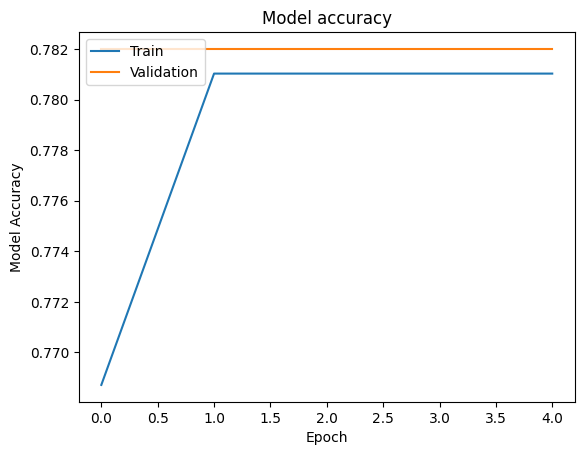

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




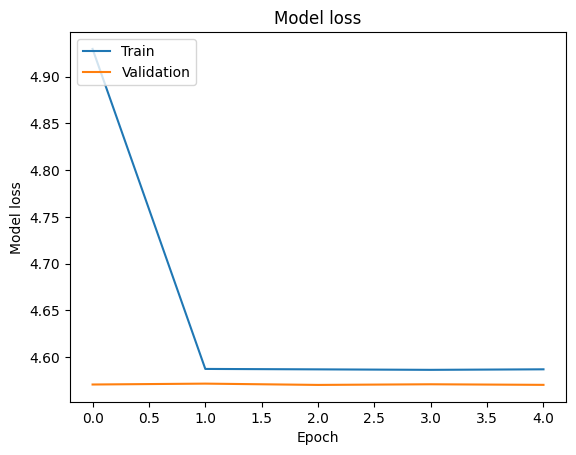

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Model loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

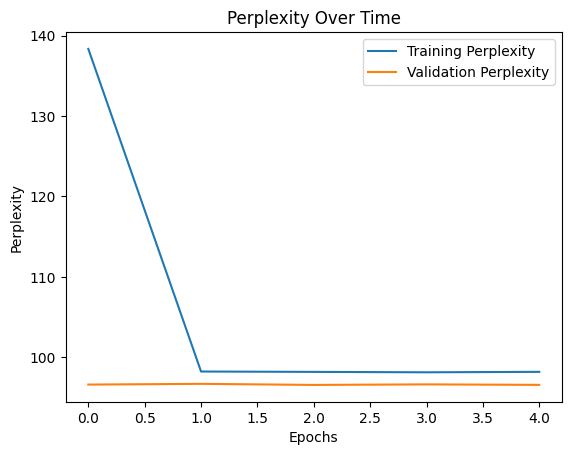

In [ ]:
import matplotlib.pyplot as plt


# Assuming 'history.history' contains the loss and val_loss over epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Calculate perplexity by exponentiating the loss for each epoch
train_perplexity = np.exp(train_loss)
val_perplexity = np.exp(val_loss)

# Plotting the perplexity over epochs
plt.plot(train_perplexity, label='Training Perplexity')
plt.plot(val_perplexity, label='Validation Perplexity')
plt.title('Perplexity Over Time')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend(loc='upper right')
plt.show()


In [ ]:
import tensorflow as tf

eval_results = model.evaluate(val_dataset)
# eval_results[0] typically corresponds to the loss (cross-entropy loss)
eval_loss = eval_results[0]  # Assuming 0 index is for loss

# Perplexity is the exponentiation of the cross-entropy loss
perplexity = tf.exp(eval_loss)

# Print the perplexity
print(f"Perplexity: {perplexity.numpy()}")

63/63 [==============================] - 24s 379ms/step - loss: 4.5703 - accuracy: 0.7820
Perplexity: 96.57335662841797


In [ ]:
%pip install colorama

In [ ]:
from huggingface_hub import notebook_login,get_full_repo_name
notebook_login()
model_name='Afriberta-Swahili-mlm_model'


In [ ]:
repo_name = get_full_repo_name(model_name)
repo_name

'Mahloromela/Afriberta-Swahili-mlm_model'

In [ ]:
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

tf_model.h5:   0%|          | 0.00/549M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Mahloromela/Afriberta-Swahili-mlm_model/commit/dcde274cfbaedbf628dde5e235e5660150386ed6', commit_message='Upload tokenizer', commit_description='', oid='dcde274cfbaedbf628dde5e235e5660150386ed6', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import pandas as pd
from transformers import pipeline, AutoTokenizer

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/NLP Project/Swahili Data2.csv")

# Take 2 samples from the 'Sentence' column
sample_texts = df['Sentence'].head(2).tolist()

# Load Afriberta tokenizer
tokenizer = AutoTokenizer.from_pretrained(repo_name)

# Load the MLM pipeline using Afriberta
mlm_pipeline = pipeline('fill-mask', model=repo_name)

# Mask a word in each sentence (replace a word with the correct mask token)
masked_texts = [
    sentence.replace(sentence.split()[2], tokenizer.mask_token)  # Masking the 4th word
    for sentence in sample_texts
]

# Perform inference to fill the masked word for each sample
for i, masked_text in enumerate(masked_texts):
    print(f"Sample {i + 1}:")
    print("Original Sentence:", sample_texts[i])
    print("Masked Sentence:", masked_text)

    # Get top predictions for the masked word
    predictions = mlm_pipeline(masked_text)

    # Print the structure of predictions for debugging
    #print("Predictions Structure:", predictions)  # Check how predictions are structured

    # Access predictions correctly
    for j in range(len(predictions)):
        # Make sure to access keys correctly, typically prediction is a dict
        prediction = predictions[j]
        print(f"Prediction: {prediction['sequence']}, Score: {prediction['score']}")
    print("\n")




tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.98M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/549M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFXLMRobertaForMaskedLM.

All the layers of TFXLMRobertaForMaskedLM were initialized from the model checkpoint at Mahloromela/Afriberta-Swahili-mlm_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForMaskedLM for predictions without further training.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Sample 1:
Original Sentence: So chuga si tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe
Masked Sentence: So chuga <mask> tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe
Prediction: So chuga tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe, Score: 1.0
Prediction: So chuga  tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe, Score: 1.5635962474542602e-20
Prediction: So chuga, tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe, Score: 1.4540277742685154e-20
Prediction: So chuga ማየት tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe, Score: 1.7980659651718135e-23
Prediction: So chuga vifaa tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho ni